In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

In [2]:
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#### Check TensorFlow

In [3]:
print(tf.__version__)

2.3.0


### Get VTI history

In [4]:
vti = yf.Ticker("VTI")
vti_hist = vti.history(period="max")

In [5]:
vti_close_hist = vti_hist.Close

In [6]:
# this is a good reminder of what day you pulled the history!!!!
vti_close_hist.tail()

Date
2020-08-05    168.84
2020-08-06    169.66
2020-08-07    169.80
2020-08-10    170.27
2020-08-11    168.90
Name: Close, dtype: float64

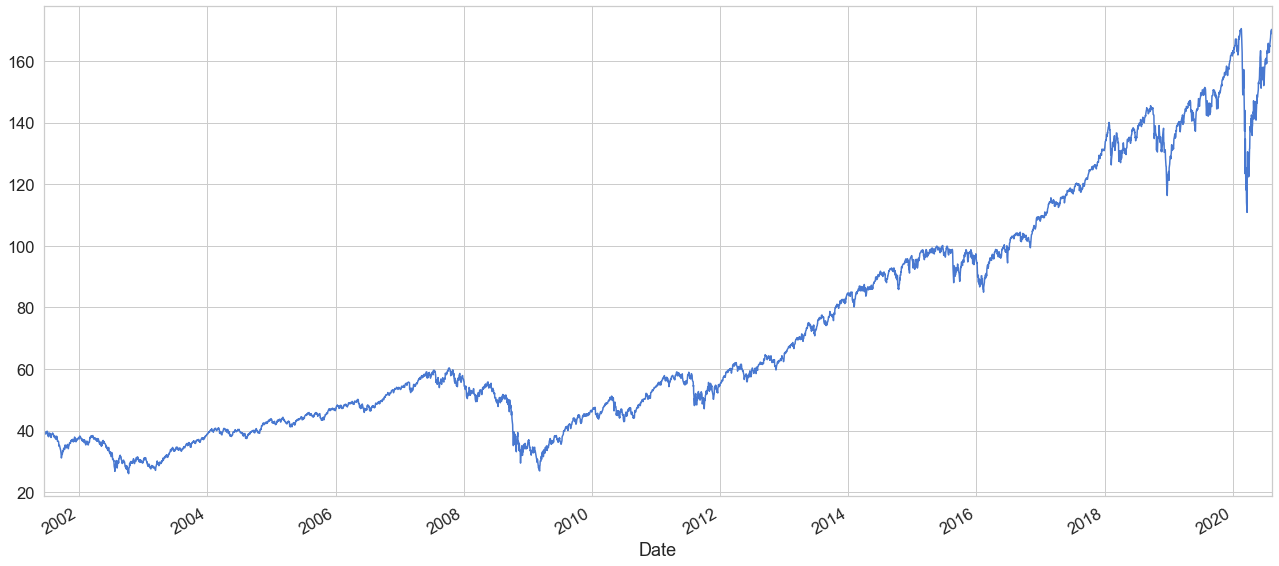

In [7]:
vti_close_hist.plot()

#### Get top 10 holding in VTI


##### * Top 10 holdings were NOT found programatically. This info has yet to be found in the vti object *

In [8]:
microsoft = yf.Ticker('MSFT').history(period="max")
apple = yf.Ticker('AAPL').history(period="max")
amazon = yf.Ticker('AMZN').history(period="max")
facebook = yf.Ticker('FB').history(period="max")
alphabetA = yf.Ticker('GOOGL').history(period="max")
alphabetC = yf.Ticker('GOOG').history(period="max")
johnson = yf.Ticker('JNJ').history(period="max")
berkshire = yf.Ticker('BRK-B').history(period="max")
visa = yf.Ticker('V').history(period="max")
proctor = yf.Ticker('PG').history(period="max")

#### Get DOW

In [9]:
dow = yf.Ticker('DJIA').history(period="max")

#### Get Gooogle Trends data

In [10]:
g_trends = pd.read_csv('vti_g_trends.csv', index_col=0)

In [11]:
g_trends.reset_index(inplace=True)

#### Convert google trends date format and upsample

In [12]:
# set first row as column names
g_trends.columns = g_trends.iloc[0]
g_trends = g_trends[1:]

In [13]:
# make month column dateframe
g_trends.Month = pd.to_datetime(g_trends.Month)

In [14]:
g_trends.set_index('Month', inplace=True)

In [15]:
# upsample: every day in month will have the monthly average
g_trends_daily = g_trends.resample('D').ffill()

In [16]:
g_trends_daily.rename(columns={'vti: (United States)': 'avg_searches', 'Month': 'Date'}, inplace=True)

In [17]:
# change ave_searches from object to numeric
g_trends_daily.avg_searches = pd.to_numeric(g_trends_daily.avg_searches)

#### Combine holdings into DF

In [18]:
df = pd.concat([vti_hist.Close.rename('vti'),
                 microsoft.Close.rename('msft'),
                 apple.Close.rename('appl'),
                 amazon.Close.rename('amzn'),
                 facebook.Close.rename('fb'),
                 alphabetA.Close.rename('google'),
                 alphabetC.Close.rename('googlb'),
                 johnson.Close.rename('jnj'),
                 berkshire.Close.rename('brk'),
                 visa.Close.rename('visa'),
                 proctor.Close.rename('pg'),
                 dow.Close.rename('dow')], join='outer', axis=1)


#### left join google trends (to accomodate for gtrends including weekends)

In [19]:
df = df.join(g_trends_daily['avg_searches'].rename('gtrnd'), how='left')

#### truncate to dates when vti is in existance

In [20]:
df = df.loc['2001-06-15':]

#### Special Cleaning for Google Trends

In [21]:
# fill the month of august with the values from the last full month
df.gtrnd.iloc[-30::].fillna(44, inplace=True)

In [22]:
df.tail(10)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2020-07-29,165.05,204.06,379.48,3033.53,233.29,1523.51,1522.02,146.54,196.41,198.58,128.31,26539.57,44.0
2020-07-30,164.68,203.90,384.07,3051.88,234.50,1538.37,1531.45,146.84,194.30,194.06,131.42,26313.65,44.0
2020-07-31,165.52,205.01,424.28,3164.68,253.67,1487.95,1482.96,145.76,195.78,190.40,131.12,26428.32,44.0
2020-08-03,166.96,216.54,434.97,3111.89,251.96,1482.76,1474.45,147.35,199.26,190.69,131.29,26664.40,44.0
2020-08-04,167.62,213.29,437.87,3138.83,249.83,1473.30,1464.97,147.22,200.24,192.29,133.79,26828.47,44.0
2020-08-05,168.84,212.94,439.46,3205.03,249.12,1479.09,1473.61,148.40,203.62,196.10,133.44,27201.52,44.0
2020-08-06,169.66,216.35,454.79,3225.00,265.28,1504.95,1500.10,147.55,205.02,198.77,132.71,27386.98,44.0
2020-08-07,169.80,212.48,444.45,3167.46,268.44,1498.37,1494.49,148.60,209.48,196.36,133.55,27433.48,44.0
2020-08-10,170.27,208.25,450.91,3148.16,263.00,1496.82,1496.10,148.03,212.58,196.79,134.10,27791.44,44.0


In [23]:
df.gtrnd.fillna(df.gtrnd.mean(), inplace=True)

### For holdings that didn't exist yet, fill NAs with its minimum price

In [24]:
for col in df.columns:
    df[col].fillna(df[col].min(), inplace=True)

## Modeling

#### Train Test Split

In [25]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

4337 482


In [26]:
f_columns = df.columns.drop('vti')

f_transformer = RobustScaler()
vti_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
vti_transformer = vti_transformer.fit(train[['vti']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['vti'] = vti_transformer.transform(train[['vti']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['vti'] = vti_transformer.transform(test[['vti']])

/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/kevinevans/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [27]:
train.head(1)

,vti,msft,appl,amzn,fb,google,googlb,jnj,brk,visa,pg,dow,gtrnd
Date,,,,,,,,,,,,,
2001-06-15,-0.324091,-0.00472,-0.316606,-0.386459,0.0,-0.557925,-0.569661,-0.340361,-0.51554,-0.164798,-0.944037,-0.249644,0.816179


In [28]:
#timeseries version of train test split
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
time_steps = 1

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.vti, time_steps)
X_test, y_test = create_dataset(test, test.vti, time_steps)

print(X_train.shape, y_train.shape)

(4336, 1, 13) (4336,)


In [30]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [31]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
122/122 [==============================] - 1s 6ms/step - loss: 0.0129 - val_loss: 0.0091
Epoch 2/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 3/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 4/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 5/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 6/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 7/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 8/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/30
122/122 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0076

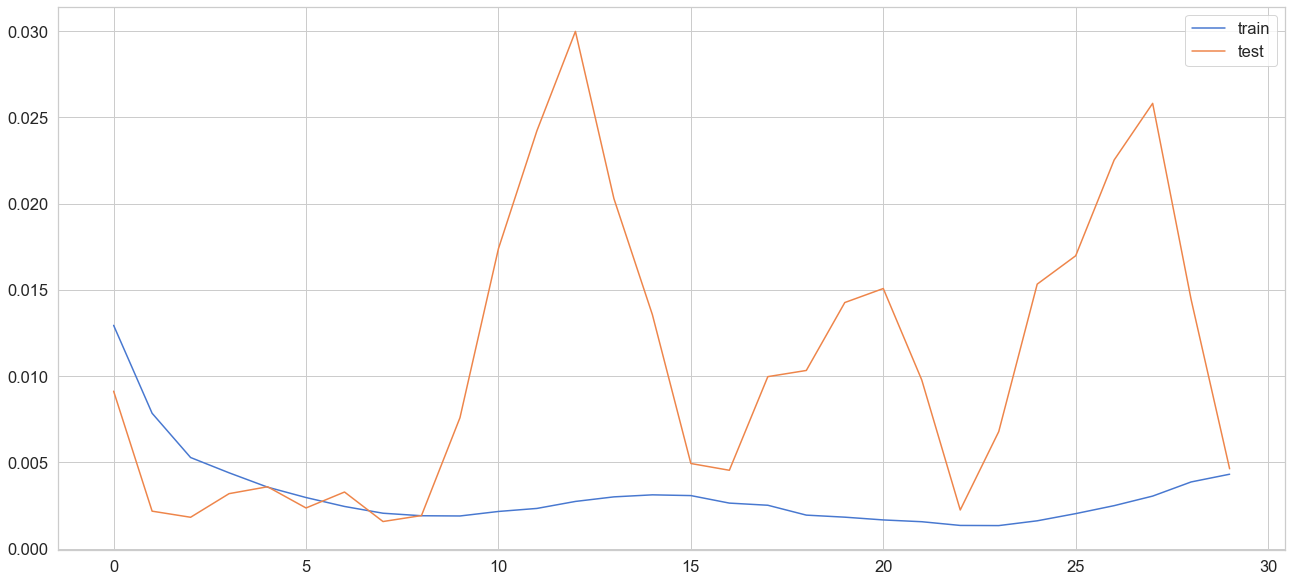

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [33]:
y_pred = model.predict(X_test)

In [34]:
y_train_inv = vti_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = vti_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = vti_transformer.inverse_transform(y_pred)

In [40]:
print("RMSE = ", np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())))
print("MAE = ", mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten()))

RMSE =  7.322160353695657
MAE =  5.354079833476807


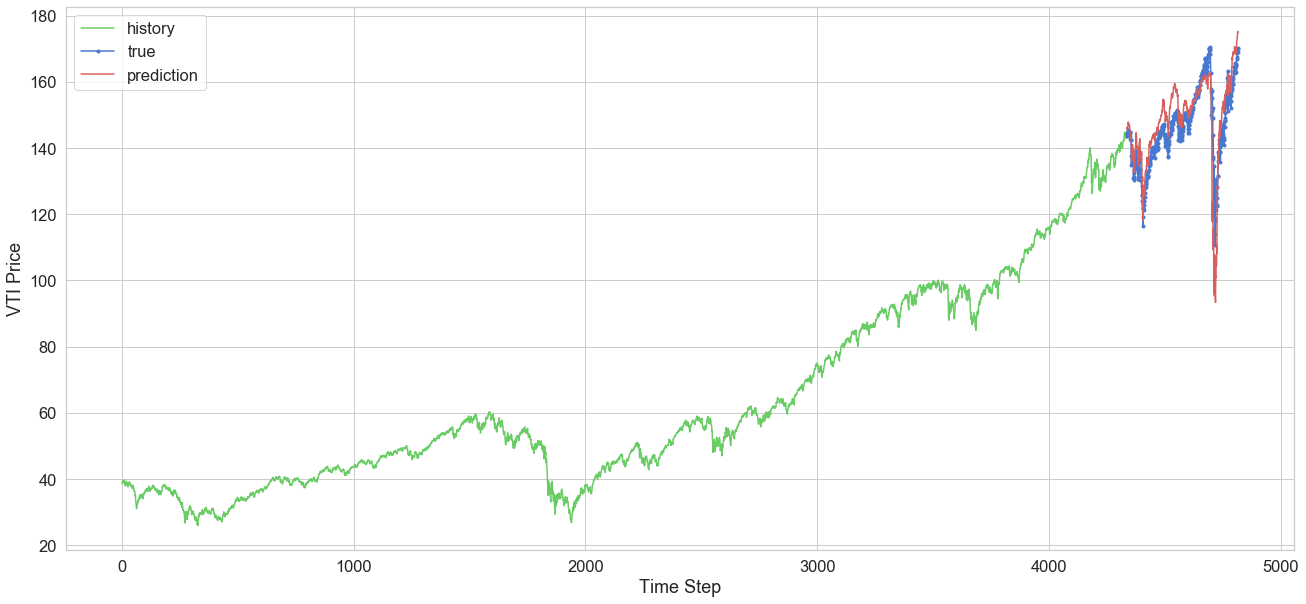

In [36]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/hist_preds_true.png')
plt.show();

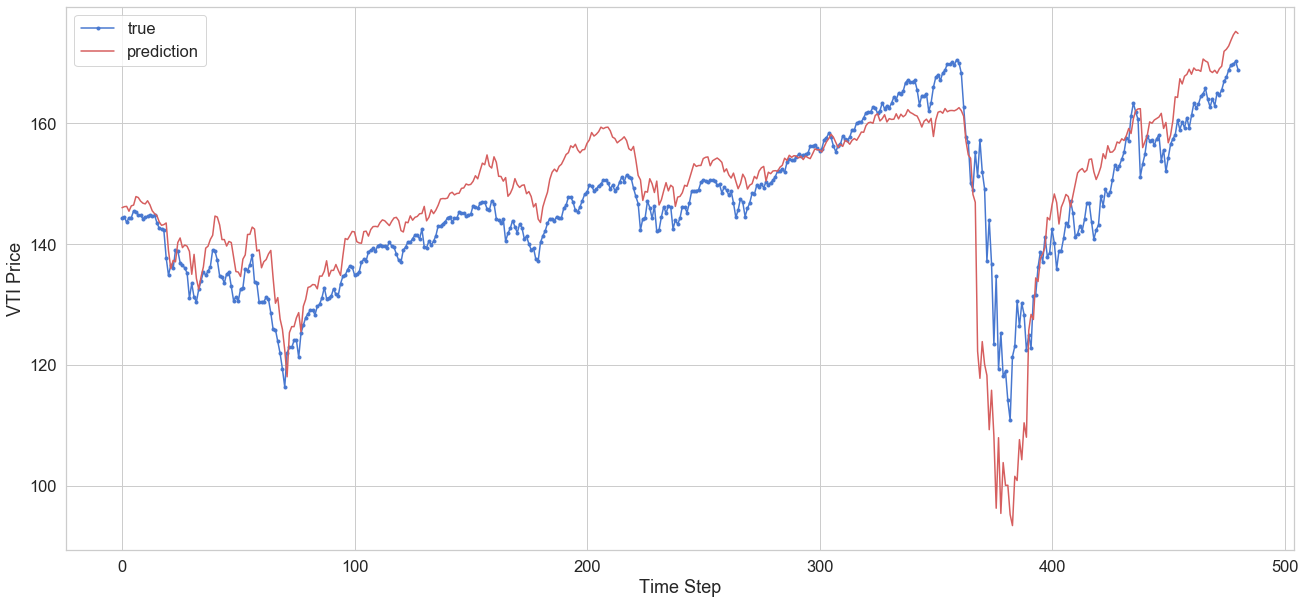

In [37]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('VTI Price')
plt.xlabel('Time Step')
plt.legend()
plt.savefig('images/lstm_preds_vs_true.png')
plt.show();
